In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mlp import MLP
from processing import patterns, persistence, shift
from metrics import all_metrics_from_dataframe
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from taylor_diagram import diagram

In [4]:
df = pd.read_csv('australia.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp').rolling(12).mean().iloc[12::12]
df.index.name = None
df = df.interpolate(method='polynomial', order=5, axis=0).clip(lower=0)

In [7]:
INPUT_SIZE = 4
TIMELAG = 18
HORIZONS = 12
INITS = 1 
HIDDEN_LAYERS = [10]
ACTIVATION = 'relu'
OPTIMIZER = 'adam'
LOSS = 'mse'
VALIDATION_SPLIT = 0.2
EPOCHS = 200

CENTRAL = 'KIATAWF1'

serie = df[CENTRAL]
index = serie.index
serie.describe()


count    8759.000000
mean       14.956560
std        10.635132
min         0.000000
25%         4.750000
50%        14.375000
75%        25.487500
max        30.900000
Name: KIATAWF1, dtype: float64

In [8]:

train, test = train_test_split(serie, test_size=.33, shuffle=False)
train_idx, test_idx = train_test_split(index, test_size=.33, shuffle=False)
X_train, Y_train = patterns(train, INPUT_SIZE, TIMELAG, HORIZONS, dropnan=True, index=train_idx)
X_test = patterns(test, INPUT_SIZE, TIMELAG, dropnan=False, index=test_idx)


In [9]:
model = MLP(input_size=INPUT_SIZE, horizons=HORIZONS, inits=INITS)
model.build(hidden_layers=HIDDEN_LAYERS, activation=ACTIVATION, optimizer=OPTIMIZER, loss=LOSS)
model.train(X_train.values, Y_train.values, validation_split=VALIDATION_SPLIT, epochs=EPOCHS)
pred = model.predict(X_test.values)
pred.index = test_idx

3950 - val_loss: 78.5104
Epoch 16/200
146/146 [==============================] - 0s 986us/step - loss: 77.2413 - val_loss: 78.5928
Epoch 17/200
146/146 [==============================] - 0s 1ms/step - loss: 77.1671 - val_loss: 78.9821
Epoch 18/200
146/146 [==============================] - 0s 1ms/step - loss: 77.0173 - val_loss: 79.2299
Epoch 19/200
146/146 [==============================] - 0s 1ms/step - loss: 76.8304 - val_loss: 79.7945
Epoch 20/200
146/146 [==============================] - 0s 1ms/step - loss: 76.7923 - val_loss: 78.1654
Epoch 21/200
146/146 [==============================] - 0s 991us/step - loss: 76.5744 - val_loss: 77.4824
Epoch 22/200
146/146 [==============================] - 0s 1ms/step - loss: 76.5334 - val_loss: 78.0685
Epoch 23/200
146/146 [==============================] - 0s 1ms/step - loss: 76.4554 - val_loss: 79.1787
Epoch 24/200
146/146 [==============================] - 0s 1ms/step - loss: 76.3085 - val_loss: 78.0410
Epoch 25/200
146/146 [=============

In [10]:
all_metrics_from_dataframe(pred, test)

,t+1,t+2,t+3,t+4,t+5,t+6,t+7,t+8,t+9,t+10,t+11,t+12
mse,17.321601,37.515734,54.581743,66.972650,76.390417,86.186646,94.390655,100.159882,107.588120,114.963538,117.076144,118.030841
rmse,4.161923,6.125009,7.387946,8.183682,8.740161,9.283676,9.715485,10.007991,10.372469,10.722105,10.820173,10.864200
bias,0.157999,0.130533,0.249804,0.527412,0.449843,0.301918,-0.157411,0.173870,-0.079243,0.447165,0.184865,0.138817
mae,2.928893,4.592199,5.712003,6.469912,7.065729,7.633399,8.112818,8.508582,8.830508,9.164187,9.313775,9.399889
mape,0.361897,0.472009,0.575130,0.570267,0.593224,0.637490,0.684508,0.653633,0.694198,0.696354,0.699244,0.688490
corr_coef,0.918571,0.813727,0.715978,0.636477,0.567153,0.490124,0.414229,0.348624,0.275961,0.207688,0.151404,0.118401
std_ratio,0.936951,0.851019,0.793609,0.729916,0.672197,0.628796,0.573700,0.514650,0.499772,0.494684,0.439411,0.406596
rmsd,4.160039,6.124183,7.384551,8.168056,8.729513,9.279232,9.714042,10.006582,10.372163,10.712608,10.818434,10.863122
ss4,0.044286,0.026667,0.015549,0.009281,0.005528,0.002919,0.001366,0.000609,0.000231,0.000073,0.000018,0.000006


In [16]:
pers = persistence(test, 12, index=test_idx)

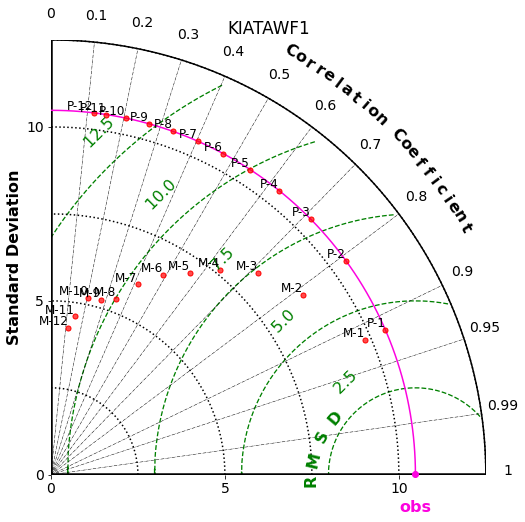

In [17]:
metrics = [all_metrics_from_dataframe(pers, test), all_metrics_from_dataframe(pred, test)]
diagram(std_obs=np.nanstd(test), metrics=metrics, names=['P','M'], savename=CENTRAL+'_'+str(HORIZONS))

: 70.6041 - val_loss: 71.3533
Epoch 19/200
145/145 [==============================] - 0s 789us/step - loss: 70.5001 - val_loss: 70.0345
Epoch 20/200
145/145 [==============================] - 0s 901us/step - loss: 70.4785 - val_loss: 70.6347
Epoch 21/200
145/145 [==============================] - 0s 1ms/step - loss: 70.3532 - val_loss: 70.5847
Epoch 22/200
145/145 [==============================] - 0s 1ms/step - loss: 70.3324 - val_loss: 72.3671
Epoch 23/200
145/145 [==============================] - 0s 1ms/step - loss: 70.3018 - val_loss: 70.8124
Epoch 24/200
145/145 [==============================] - 0s 897us/step - loss: 70.1727 - val_loss: 70.8438
Epoch 25/200
145/145 [==============================] - 0s 851us/step - loss: 70.0782 - val_loss: 71.2351
Epoch 26/200
145/145 [==============================] - 0s 884us/step - loss: 70.0675 - val_loss: 72.5086
Epoch 27/200
145/145 [==============================] - 0s 1ms/step - loss: 70.0075 - val_loss: 71.0072
Epoch 28/200
145/145 [==

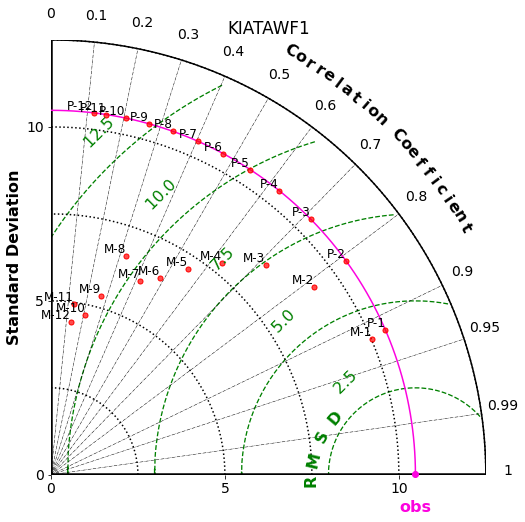

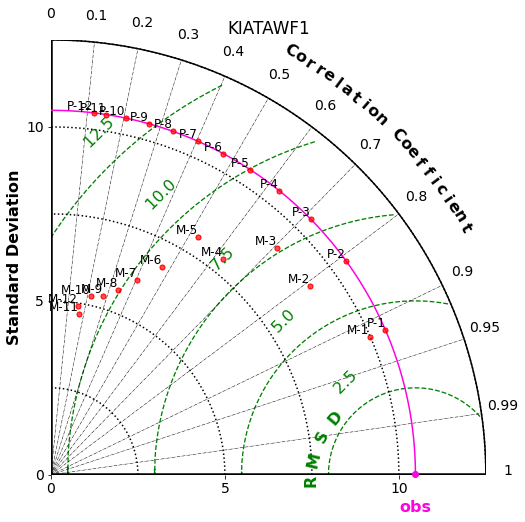

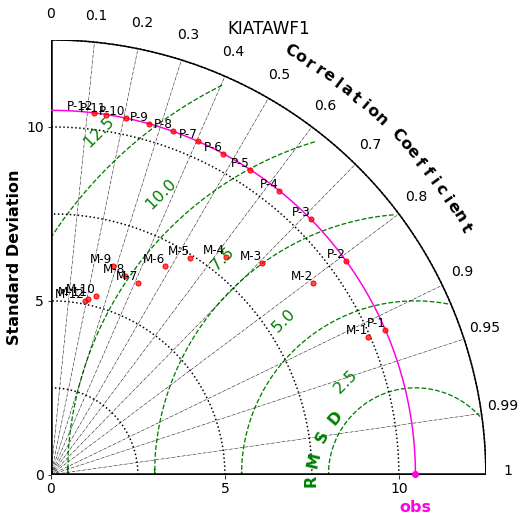

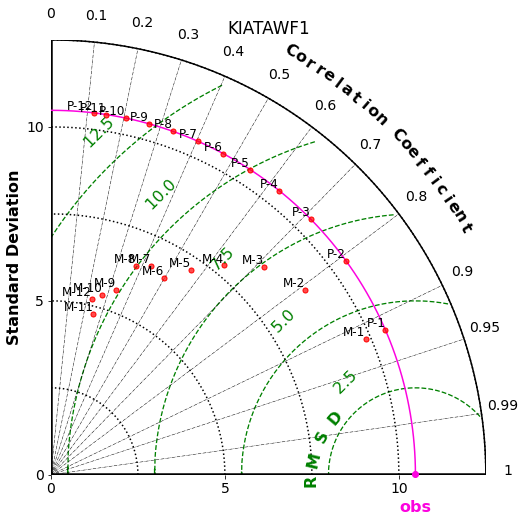

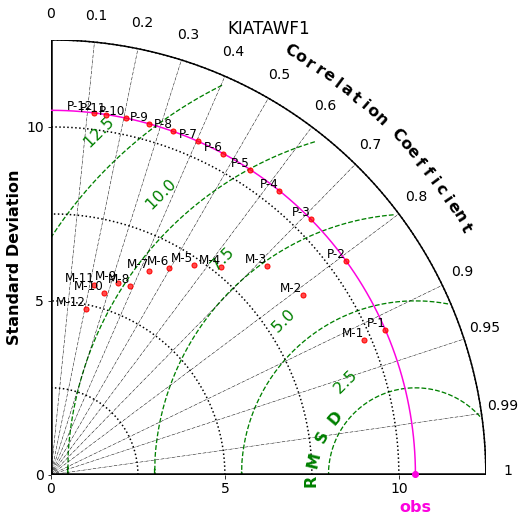

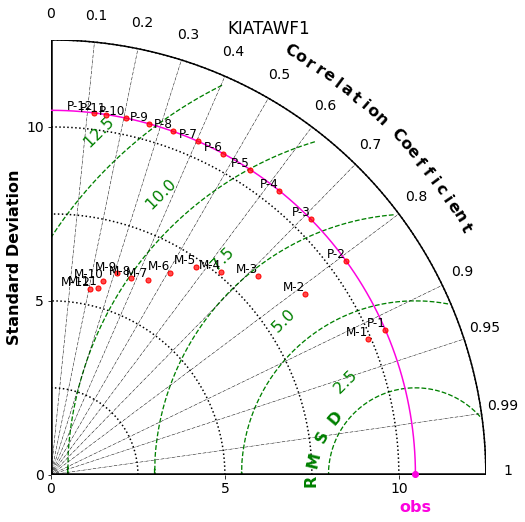

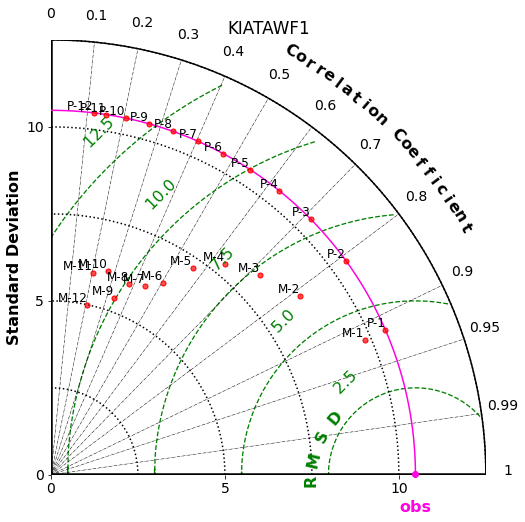

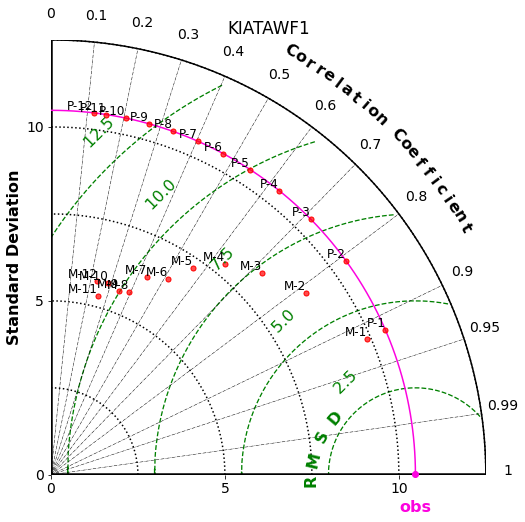

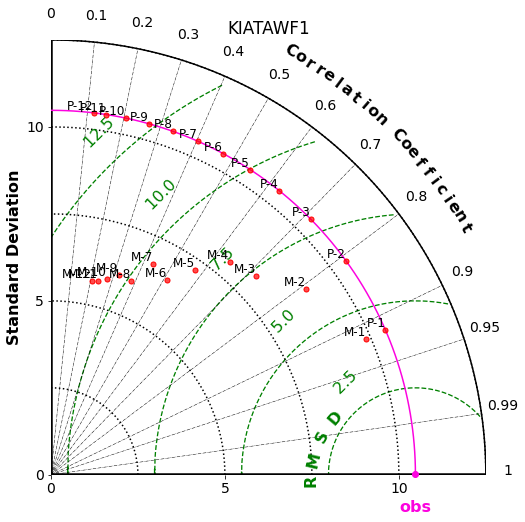

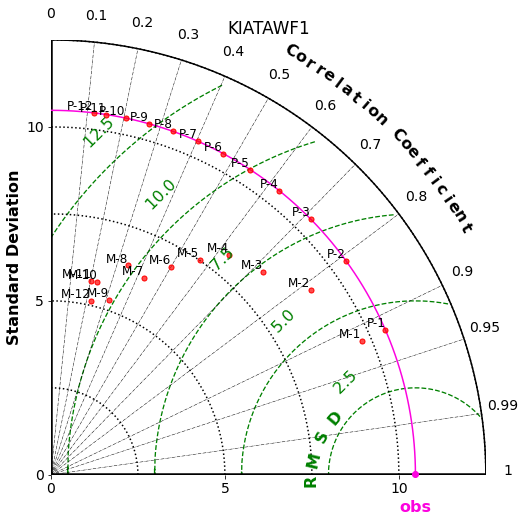

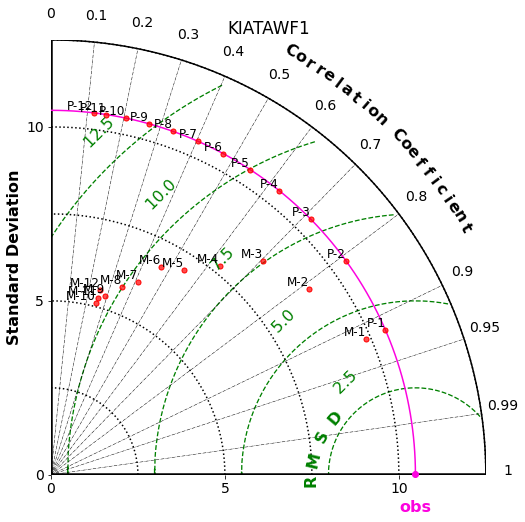

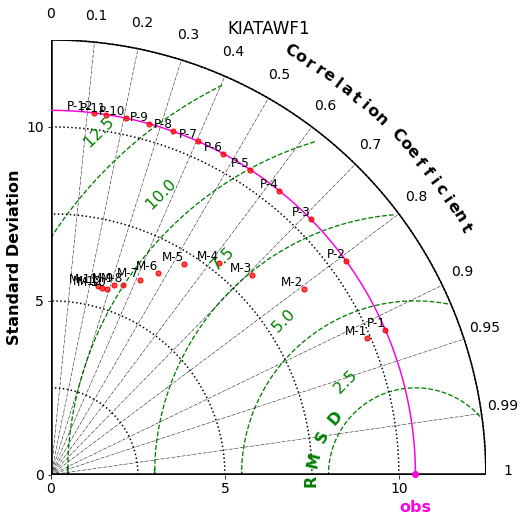

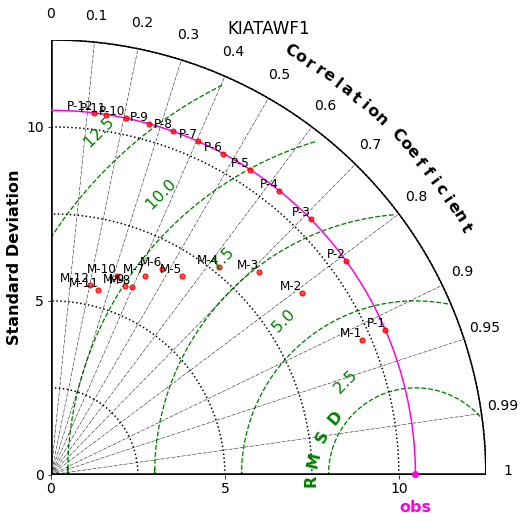

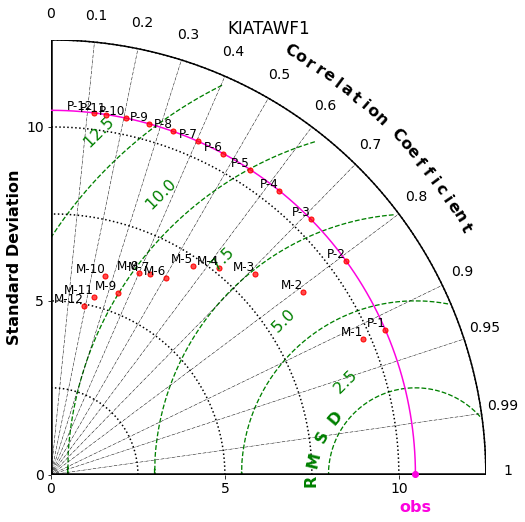

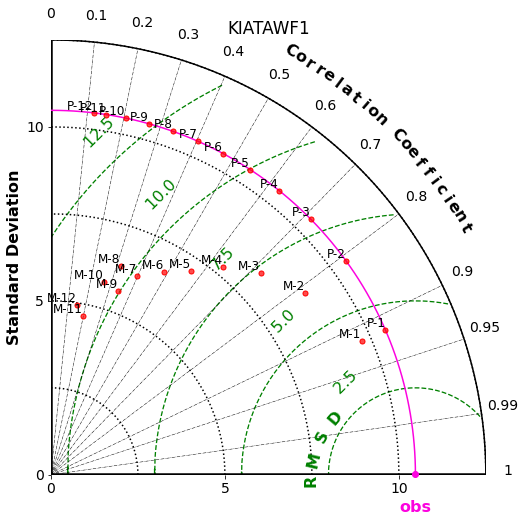

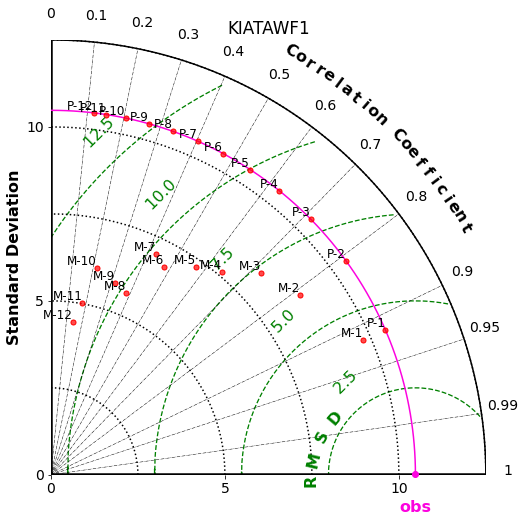

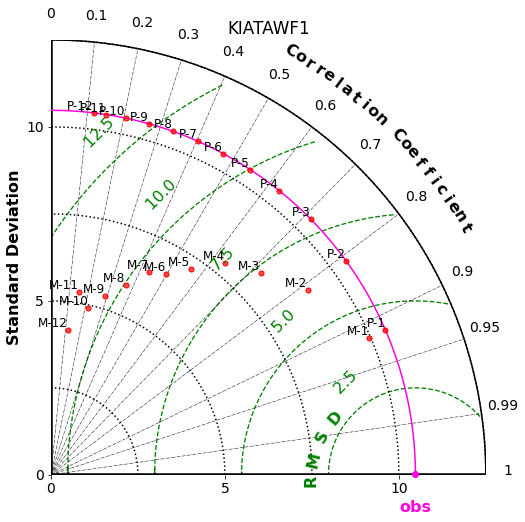

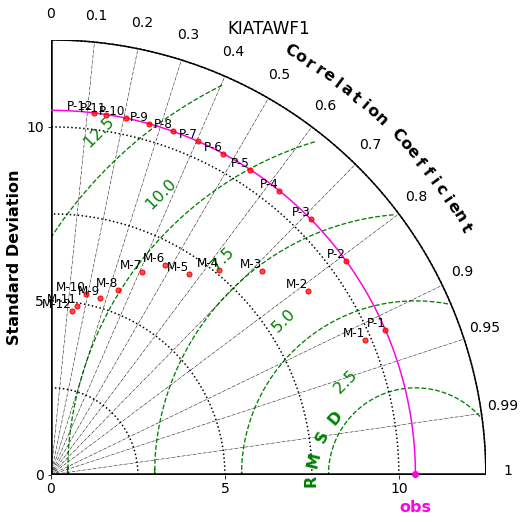

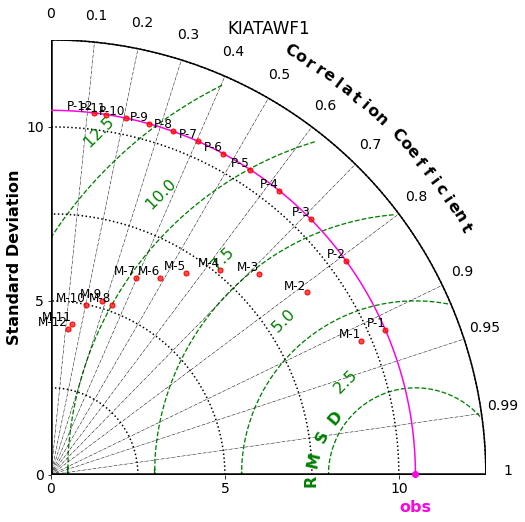

In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from mlp import MLP
from processing import patterns, persistence
from metrics import all_metrics_from_dataframe
from taylor_diagram import diagram

df = pd.read_csv('australia.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp').rolling(6).mean().iloc[6::6]
df.index.name = None
df = df.interpolate(method='polynomial', order=5, axis=0).clip(lower=0)

INPUT_SIZE = 4
HORIZONS = 12
INITS = 1 
HIDDEN_LAYERS = [10]
ACTIVATION = 'relu'
OPTIMIZER = 'adam'
LOSS = 'mse'
VALIDATION_SPLIT = 0.2
EPOCHS = 200

CENTRAL = 'KIATAWF1'

serie = df[CENTRAL]
index = serie.index
serie.describe()

train, test = train_test_split(serie, test_size=.33, shuffle=False)
train_idx, test_idx = train_test_split(index, test_size=.33, shuffle=False)

pers = persistence(test, horizons=HORIZONS, index=test_idx)

for TIMELAG in range(1,49):

    X_train, Y_train = patterns(train, INPUT_SIZE, TIMELAG, HORIZONS, dropnan=True, index=train_idx)
    X_test = patterns(test, INPUT_SIZE, TIMELAG, dropnan=False, index=test_idx)

    model = MLP(input_size=INPUT_SIZE, horizons=HORIZONS, inits=INITS)
    model.build(hidden_layers=HIDDEN_LAYERS, activation=ACTIVATION, optimizer=OPTIMIZER, loss=LOSS)
    model.train(X_train.values, Y_train.values, validation_split=VALIDATION_SPLIT, epochs=EPOCHS)
    pred = model.predict(X_test.values)
    pred.index = test_idx

    metrics = [all_metrics_from_dataframe(pers, test), all_metrics_from_dataframe(pred, test)]
    diagram(std_obs=np.nanstd(test), metrics=metrics, names=['P','M'], title=CENTRAL, savename=CENTRAL+'_'+str(TIMELAG))
# %%
